## Embeddings

Cada modelo tiene todos los vídeos y la etiqueta en la columna **shoot_zone**,  donde lanzamiento a la derecha es 0, al centro es 1 y a la izquierda  es 2. 

| Fichero                      | Modelo          | Comentarios sobre “\_SUFIJO”                              |
| ---------------------------- | --------------- | --------------------------------------------------------- |
| **baseline\_CASIAB.csv**     | Baseline        | Versión “base” (p.ej. GEINet simple) entrenada en CASIA-B |
| **baseline\_OUMVLP.csv**     | Baseline        | Igual que el anterior, pero pre-entrenado en OU-MVLP      |
| **gaitgl.csv**               | GaitGL          | GaitGL estándar (dataset por defecto, p.ej. CASIA-B)      |
| **gaitgl\_OUMVLP.csv**       | GaitGL          | Pre-entrenado en OU-MVLP                                  |
| **gaitgl\_GREW\.csv**        | GaitGL          | Pre-entrenado en GREW                                     |
| **gaitgl\_GREW\_BNNeck.csv** | GaitGL + BNNeck | Mismo que el anterior, con cuello de batch-norm extra     |
| **gaitpart.csv**             | GaitPart        | GaitPart estándar                                         |
| **gaitpart\_OUMVLP.csv**     | GaitPart        | Pre-entrenado en OU-MVLP                                  |
| **gaitpart\_GREW\.csv**      | GaitPart        | Pre-entrenado en GREW                                     |
| **gaitset.csv**              | GaitSet         | GaitSet estándar                                          |
| **gaitset\_OUMVLP.csv**      | GaitSet         | Pre-entrenado en OU-MVLP                                  |
| **gaitset\_GREW\.csv**       | GaitSet         | Pre-entrenado en GREW                                     |
| **gln\_phase1.csv**          | GLN (fase 1)    | Primer bloque/fase de extracción del modelo “GLN”         |
| **gln\_phase2.csv**          | GLN (fase 2)    | Fase de refinamiento o bloque final del mismo “GLN”       |


In [ ]:
import os
import pandas as pd

# 1. Directorio con los CSV
data_dir = "Gait_Embeddings_good/"

# 2. Listar sólo los archivos .csv
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
print("Archivos encontrados:", csv_files)

# 3. Leer cada CSV en un DataFrame de pandas
dfs = {}
for fname in csv_files:
    path = os.path.join(data_dir, fname)
    dfs[fname] = pd.read_csv(path)

# 4. Explorar cada DataFrame
for name, df in dfs.items():
    print(f"\n=== {name} ===")
    print("Shape:", df.shape)                  # filas × columnas
    print("Columnas:", df.columns.tolist())    # lista de nombres
    print("Primeras 5 filas:")
    print(df.head().to_string(index=False))    # muestra las primeras filas

    # Opcional: ver tipo de datos y memoria
    print("\nInfo:")
    print(df.info())
    print("\nDescripción estadística de columnas numéricas:")
    print(df.describe().T)  # transpuesta para leer mejor


## Metodología de desarrollo

1️⃣ datos → 2️⃣ preprocesado y normalización → 3️⃣ split → 4️⃣ Dataset/DataLoader (+ collate) → 5️⃣ modelo → 6️⃣ entrenamiento (función de pérdida y optimizador) → 7️⃣ evaluación → 8️⃣ ajuste → 9️⃣ guardado.

- Entender y explorar los datos

- Inspecciona las columnas, tipos de variables, balance de clases, valores faltantes y rangos.

- Visualiza distribuciones y posibles outliers.

- Limpieza y preprocesado

- Trata valores faltantes (imputación o eliminación).

- Normalización / escalado

- Aplica Min–Max o Z-score (standarización) para que todas las características queden en un rango controlado y evites que alguna domine el entrenamiento.

- En embeddings, a veces se usa L₂-norm para cada vector si quieres que tengan norma unidad.

- Dividir en train / validation / test

- Reserva al menos un 10–20 % para test “final”.

- Dentro del train crea validación (p. ej. 80/20 o K-fold) para ajustar hiperparámetros sin tocar el test.

- Definir Dataset y DataLoader para construir batches

- Definir el modelo

- Elegir función de pérdida y optimizador

- Bucle de entrenamiento

- Ajuste de hiperparámetros

- Guardado y almacenado de los pesos con torch.save(model.state_dict(), 'modelo.pt').







### Librerías 

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

In [ ]:
# Configuración del dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Guardado de los Modelos

In [ ]:


def save_model(model, path: str):
    """
    Guarda en 'path' únicamente los pesos (state_dict) de `model`.
    """
    torch.save(model.state_dict(), path)
    print(f"Modelo guardado en {path}\n")


def load_model(model_class, path, device=DEVICE, **model_kwargs):
    """
    Carga un modelo de cualquier clase PyTorch definida por el usuario.
    
    Parámetros:
    - model_class: la clase del modelo (MLPClassifier, LSTMClassifier, TransformerClassifier, etc.)
    - path:        ruta al archivo .pth con state_dict()
    - device:      dispositivo donde cargar el modelo (ej. DEVICE)
    - **model_kwargs: argumentos para instanciar la clase de modelo 
                      (input_dim, hidden_dim, num_layers, ...)
    """
    # Instancia la arquitectura con los kwargs
    model = model_class(**model_kwargs).to(device)
    # Carga pesos entrenados
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()
    return model

-----------------------------------------------------------------------
## Modelo MLP

In [ ]:
#MLP sencillo con pooling previo
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        """
        input_dim: dimensión D del embedding tras pooling
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 3)  # 3 clases: derecha, centro, izquierda
        )

    def forward(self, x):
        # x: (batch_size, D)
        return self.net(x)


## Preparación de datos, split y bucle de entrenamiento: MLP
Al preparar los datos para el MLP, primero agrupamos todas las filas del CSV que pertenecen a un mismo video_ID en una matriz de tamaño (T, D), donde T es el número de frames de ese vídeo y D las 256 características por frame. A continuación aplicamos mean‐pooling o max‐pooling sobre el eje temporal T, colapsando cada matriz a un único vector de dimensión (D,) que resume toda la aproximación del jugador al penalti. Ese conjunto de vectores —uno por vídeo— se divide de forma estratificada en train y test, de modo que en el entrenamiento el DataLoader extrae batches de tamaño fijo (por ejemplo 32) con esos vectores y sus etiquetas, y así el MLP aprende a clasificar la dirección del lanzamiento usando esos resúmenes globales.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import TensorDataset, DataLoader



def prepare_mlp_data(df, pooling, norm, test_size=0.2):
    # 1) Pooling temporal
    feat_cols = [c for c in df.columns if c.startswith('feat_')]
    seqs, labs = [], []
    for vid, grp in df.groupby('video_ID'):
        arr = grp[feat_cols].values.astype(np.float32)  # (T, D)
        vec = arr.mean(axis=0) if pooling=='mean' else arr.max(axis=0)
        seqs.append(vec)
        labs.append(int(grp['shoot_zone'].iloc[0]))
    X = np.stack(seqs)  # (N, D)
    y = np.array(labs, dtype=np.int64)

    # 2) Normalización
    if norm == 'minmax':
        X = MinMaxScaler().fit_transform(X)
    elif norm == 'L2':  # 'l2'
        X = normalize(X, norm='l2')

    # 3) Split estratificado
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

    # 4) TensorDatasets
    tr_ds = TensorDataset(torch.from_numpy(Xtr).float(),
                          torch.from_numpy(ytr))
    te_ds = TensorDataset(torch.from_numpy(Xte).float(),
                          torch.from_numpy(yte))
    return tr_ds, te_ds

def run_training(model, train_loader, test_loader, epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # REVISAR
    loss_fn   = nn.CrossEntropyLoss()
    history   = {'train_loss':[], 'test_acc':[], 'test_f1':[]}

    for ep in range(1, epochs+1):
        # entrenamiento
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = loss_fn(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * yb.size(0)
        history['train_loss'].append(total_loss / len(train_loader.dataset))

        # evaluación
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb = xb.to(DEVICE)
                preds = model(xb).argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.numpy())
        all_preds  = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        acc = accuracy_score(all_labels, all_preds)
        f1  = f1_score(all_labels, all_preds, average='macro')
        history['test_acc'].append(acc)
        history['test_f1'].append(f1)

        print(f"Ep{ep:02d} | loss {history['train_loss'][-1]:.4f} "
              f"| acc {acc:.4f} | f1_macro {f1:.4f}")

    return history


## Entrenamiento

In [ ]:
import os
import pandas as pd
from torch.utils.data import DataLoader

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "Gait_Embeddings_good"
POOLS    = ['mean', 'max']
NORMS    = ['minmax', 'L2']
EPOCHS   = 1000
BATCH    = 64
LOAD_MODEL = False  # Si True, carga un modelo preentrenado en lugar de entrenar uno nuevo

PATH = "saved_models/MLP/"
os.makedirs(PATH, exist_ok=True)

results = []

for fname in os.listdir(DATA_DIR):
    if not fname.endswith('.csv'):
        continue
    print(f"\n--- Entrenando MLP con {fname} ---")
    df = pd.read_csv(os.path.join(DATA_DIR, fname))

    for pool in POOLS:
        for norm in NORMS:
            tr_ds, te_ds = prepare_mlp_data(df, pooling=pool, norm=norm, test_size=0.2)
            tr_loader = DataLoader(tr_ds, batch_size=BATCH, shuffle=True)
            te_loader = DataLoader(te_ds, batch_size=BATCH)

            model = MLPClassifier(tr_ds[0][0].shape[0]).to(DEVICE) 
            
            # Si LOAD_MODEL es True, intenta cargar un modelo preentrenado
            if LOAD_MODEL == True:
                model_path = os.path.join(PATH, f"mlp_{pool}_{norm}_{fname.replace('.csv', '')}.pth")
                if os.path.exists(model_path):
                    print(f"Cargando modelo preentrenado desde {model_path}")
                    model = load_model(MLPClassifier, model_path, input_dim=tr_ds[0][0].shape[0])
            
            history = run_training(model, tr_loader, te_loader, epochs=EPOCHS, lr=1e-3)

            results.append({
                'extractor':     fname,
                'model':         'MLP',
                'epochs':        EPOCHS,
                'batch_size':    BATCH,
                'pooling':       pool,
                'normalization': norm,
                'accuracy':      round(history['test_acc'][-1], 5),
                'f1_macro':      round(history['test_f1'][-1], 5)
            })
            
            # Guardar modelo
            model_path = os.path.join(PATH, f"mlp_{pool}_{norm}_{fname.replace('.csv', '')}.pth")
            save_model(model, model_path)


# Guardar resultados finales
df_res = pd.DataFrame(results)
df_res.to_csv(f"results/mlp_penalty_results_{BATCH}.csv", index=False)
print("\n✅ Resultados guardados en mlp_penalty_results.csv")


## Matriz de Confusión y Curva ROC

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def evaluate_confusion_matrix(model, dataloader, device, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for batch in dataloader:
            # Adaptar según tu DataLoader (2 ó 3 elementos)
            if len(batch) == 3:
                xb, lengths, yb = batch
                xb, lengths = xb.to(device), lengths.to(device)
                logits = model(xb, lengths)
            else:
                xb, yb = batch
                xb = xb.to(device)
                logits = model(xb)

            preds = logits.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Dibujar
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Matriz de Confusión")
    plt.colorbar()
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Etiqueta predicha")
    plt.tight_layout()
    plt.show()
    return cm



def evaluate_multiclass_roc(model, dataloader, device, class_names):
    model.eval()
    y_true, y_score = [], []

    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:
                xb, lengths, yb = batch
                xb, lengths = xb.to(device), lengths.to(device)
                logits = model(xb, lengths)
            else:
                xb, yb = batch
                xb = xb.to(device)
                logits = model(xb)

            probs = F.softmax(logits, dim=1).cpu().numpy()
            y_score.append(probs)
            y_true.append(yb.numpy())

    y_true = np.concatenate(y_true)
    y_score = np.concatenate(y_score)
    n_classes = y_score.shape[1]
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    plt.figure(figsize=(6,5))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    plt.plot([0,1], [0,1], 'k--', label="Azar")
    plt.xlabel("Tasa Falsos Positivos")
    plt.ylabel("Tasa Verdaderos Positivos")
    plt.title("ROC Multi-clase (One-vs-Rest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()


In [ ]:
# Asumiendo que ya tienes un modelo entrenado y un DataLoader de test
class_names = ['derecha', 'centro', 'izquierda']
evaluate_multiclass_roc(model, te_loader, DEVICE, class_names)
cm = evaluate_confusion_matrix(model, te_loader, DEVICE, class_names)

# Numero de aciertos y errores
print("\n=== Resultados de la matriz de confusión para test ===")
print("Aciertos (diagonal):", np.diag(cm).sum())
print("Errores (fuera de la diagonal):", cm.sum() - np.diag(cm).sum())


-------------------------------------------------------------------------------
## Modelo LSTM y BiLSTM

In [ ]:
#LSTM (o BiLSTM) con salida densa
class LSTMClassifier(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim=128,
        num_layers=2,
        bidirectional=False,
        dropout=0.5):

        """
        input_dim: dimensión D del embedding sin pooling (secuencia)
        hidden_dim: tamaño de la capa oculta LSTM
        num_layers: número de capas LSTM
        bidirectional: si usar BiLSTM
        dropout: dropout entre capas LSTM (si num_layers > 1)
        """
        
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        final_dim = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(final_dim, 3)

    def forward(self, x, lengths):
        """
        x: tensor FloatTensor de forma (B, T, D)
        lengths: LongTensor con longitudes reales de cada secuencia (B,)
        """
        # Empaquetar secuencias variables
        packed = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (h_n, _) = self.lstm(packed)
        # h_n tiene forma (num_layers * num_directions, B, hidden_dim)
        # Extraemos la última capa de la última dirección
        if self.lstm.bidirectional:
            # Dos direcciones: concatenar capa final forward y backward
            h_forward = h_n[-2]  # última capa forward
            h_backward = h_n[-1]  # última capa backward
            h_final = torch.cat([h_forward, h_backward], dim=1)
        else:
            # Solo una dirección
            h_final = h_n[-1]
        return self.fc(h_final)



## Preparación de datos, split y bucle de entrenamiento: LSTM

In [23]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

def collate_sequences(batch):
    """
    Recibe una lista de (tensor_seq, label).
    Devuelve:
      - padded: tensor (B, T_max, D)
      - lengths: tensor (B,)
      - labels: tensor (B,)
    """
    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, labels

def prepare_seq_data(df, norm, test_size=0.2):
    """
    df: DataFrame con columnas feat_0…feat_D-1, video_ID y shoot_zone
    norm: 'minmax' o 'l2'
    Devuelve dos listas de muestras (tensor_seq, label) para train y test.
    """
    # 1) Extraer todas las secuencias y etiquetas
    feat_cols = [c for c in df.columns if c.startswith('feat_')]
    seqs, labs = [], []
    for vid, grp in df.groupby('video_ID'):
        arr = grp[feat_cols].values.astype(np.float32)  # (T, D)
        seqs.append(arr)
        labs.append(int(grp['shoot_zone'].iloc[0]))

    # 2) Normalizar
    if norm == 'minmax':
        all_frames = np.vstack(seqs)
        scaler = MinMaxScaler().fit(all_frames)
        seqs = [scaler.transform(s) for s in seqs]
    elif norm == 'L2':  # L2-norm por frame
        seqs = [normalize(s, norm='l2', axis=1) for s in seqs]

    # 3) Split estratificado
    idx = list(range(len(seqs)))
    idx_tr, idx_te = train_test_split(
        idx, test_size=test_size, stratify=labs, random_state=42)

    # 4) Convertir a listas de tuplas (tensor_seq, label)
    train_list = [(torch.from_numpy(seqs[i]), labs[i]) for i in idx_tr]
    test_list  = [(torch.from_numpy(seqs[i]), labs[i]) for i in idx_te]


    return train_list, test_list


def run_training_lstm(model, train_loader, test_loader, epochs, lr):
    """
    Función de entrenamiento específica para el modelo LSTM
    Args:
        model: Instancia de LSTMClassifier
        train_loader: DataLoader con datos de entrenamiento (incluye lengths)
        test_loader: DataLoader con datos de test (incluye lengths)
        epochs: Número de épocas de entrenamiento
        lr: Learning rate para el optimizador
    Returns:
        history: Diccionario con métricas de entrenamiento
    """
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss': [],'test_loss':[], 'test_acc': [], 'test_f1': []}

    patience = 100  # Paciencia para early stopping
    min_delta = 0.0005  # Mínima mejora para considerar que hay progreso
    best_loss = float('inf')  # Mejor pérdida inicial
    epochs_no_improve = 0  # Contador de épocas sin mejora

    for ep in range(1, epochs + 1):
        # --- TRAIN ---
        model.train()
        total_loss = 0
        for xb, lengths, yb in train_loader:
            # Mover datos a GPU/CPU
            xb = xb.to(device)
            lengths = lengths.to(device)
            yb = yb.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            out = model(xb, lengths)
            loss = loss_fn(out, yb)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * yb.size(0)
        
        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)

        # --- TEST ---
        model.eval()
        all_preds, all_labels = [], []
        #test_sum = 0
        
        with torch.no_grad():
            for xb, lengths, yb in test_loader:
                xb = xb.to(device)
                lengths = lengths.to(device)
                
                # Predicción
                outputs = model(xb, lengths)
                preds = outputs.argmax(dim=1).cpu().numpy()
                
                #test_sum += loss_fn(outputs, yb).item() * yb.size(0)
                
                all_preds.append(preds)
                all_labels.append(yb.numpy())

        # Calcular métricas
        #avg_test_loss = test_sum / len(test_loader.dataset)
        #history['test_loss'].append(avg_test_loss)

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        history['test_acc'].append(acc)
        history['test_f1'].append(f1)

        # Imprimir progreso
        print(f"Época {ep:02d}/{epochs} | "
              f"train_loss {avg_loss:.4f} | "
              f"accuracy {acc:.4f} | "
              f"f1_macro {f1:.4f}")
        

        # — Early stopping basado en test_loss —
        if ep > 300:
            if avg_loss < best_loss - min_delta:
                best_loss = avg_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping tras {epochs_no_improve} épocas "
                          f"sin mejorar el train_loss (delta<{min_delta}).")
                    break

    return history

## Entrenamiento

In [24]:

# Configuración
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_DIR = "Gait_Embeddings_good"
EPOCHS = 1000
BATCH = 128
LR = 1e-3
# WD = WEIGHT_DECAY
NORMS = ['minmax','L2']
LOAD_MODEL = False  # Si True, carga un modelo preentrenado en lugar de entrenar uno nuevo

# Hiperparámetros de LSTM
num_layers    = 2
hidden_dim    = 128
bidirectional = False
dropout       = 0.5

results_lstm = []


for fname in os.listdir(DATA_DIR):
    if not fname.endswith('.csv'):
        continue
        
    print(f"\n--- Entrenando LSTM con {fname} ---")
    df = pd.read_csv(os.path.join(DATA_DIR, fname))
    
    for norm in NORMS:
        # Preparar datos
        train_list, test_list = prepare_seq_data(df, norm=norm)
        tr_loader = DataLoader(train_list, batch_size=BATCH, shuffle=True, collate_fn=collate_sequences)
        te_loader = DataLoader(test_list, batch_size=BATCH, shuffle=False, collate_fn=collate_sequences)

        # Crear y entrenar modelo
        model = LSTMClassifier(
            input_dim=df.filter(like='feat_').shape[1],
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            bidirectional=False,
            dropout=dropout
        ).to(DEVICE)
        
        # Si LOAD_MODEL es True, intenta cargar un modelo preentrenado
        if LOAD_MODEL:
            model_path = os.path.join("saved_models/LSTM", f"lstm_{norm}_{fname.replace('.csv', '')}.pth")
            if os.path.exists(model_path):
                print(f"Cargando modelo preentrenado desde {model_path}")
                model = load_model(LSTMClassifier, model_path, input_dim=df.filter(like='feat_').shape[1])

        history = run_training_lstm(model, tr_loader, te_loader, epochs=EPOCHS, lr=LR) 

        # Guardar resultados
        results_lstm.append({
            'extractor': fname,
            'model': 'LSTM',
            'epochs': EPOCHS,
            'batch_size': BATCH,
            'normalization': norm,
            'num_layers': num_layers,
            'hidden_dim': hidden_dim,
            'bidirectional': bidirectional,
            'dropout': dropout,
            'lr': LR,
            'train_loss': round(history['train_loss'][-1], 5),
            'accuracy': round(history['test_acc'][-1], 5),
            'f1_macro': round(history['test_f1'][-1], 5)
        })

        # Guardar modelo
        model_path = os.path.join("saved_models/LSTM", f"lstm_{norm}_hidden{hidden_dim}_layers{num_layers}_batch{BATCH}_{fname.replace('.csv', '')}.pth")
        save_model(model, model_path)


df_results = pd.DataFrame(results_lstm)
df_results.to_csv(f"results/lstm_results.csv", index=False)
print(f"\n✅ Resultados LSTM guardados en lstm_results_{BATCH}.csv")



--- Entrenando LSTM con baseline_CASIAB.csv ---
Época 01/1000 | train_loss 1.0670 | accuracy 0.4828 | f1_macro 0.2171
Época 02/1000 | train_loss 1.0225 | accuracy 0.4828 | f1_macro 0.2171
Época 03/1000 | train_loss 1.0186 | accuracy 0.4828 | f1_macro 0.2171
Época 04/1000 | train_loss 1.0102 | accuracy 0.4828 | f1_macro 0.2171
Época 05/1000 | train_loss 1.0121 | accuracy 0.4828 | f1_macro 0.2171
Época 06/1000 | train_loss 1.0124 | accuracy 0.4828 | f1_macro 0.2171
Época 07/1000 | train_loss 1.0106 | accuracy 0.4828 | f1_macro 0.2171
Época 08/1000 | train_loss 1.0096 | accuracy 0.4828 | f1_macro 0.2171
Época 09/1000 | train_loss 1.0064 | accuracy 0.4828 | f1_macro 0.2171
Época 10/1000 | train_loss 1.0115 | accuracy 0.4828 | f1_macro 0.2171
Época 11/1000 | train_loss 1.0063 | accuracy 0.4828 | f1_macro 0.2171
Época 12/1000 | train_loss 1.0065 | accuracy 0.4828 | f1_macro 0.2171
Época 13/1000 | train_loss 1.0075 | accuracy 0.4828 | f1_macro 0.2171
Época 14/1000 | train_loss 1.0098 | accur

C:\Users\grial_h2phao1\AppData\Local\Temp\ipykernel_13948\3703025695.py:25: DtypeWarning: Columns (129) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(DATA_DIR, fname))


Época 01/1000 | train_loss 1.0993 | accuracy 0.5455 | f1_macro 0.2353
Época 02/1000 | train_loss 1.0530 | accuracy 0.5455 | f1_macro 0.2353
Época 03/1000 | train_loss 1.0201 | accuracy 0.5455 | f1_macro 0.2353
Época 04/1000 | train_loss 0.9833 | accuracy 0.5455 | f1_macro 0.2353
Época 05/1000 | train_loss 0.9525 | accuracy 0.5455 | f1_macro 0.2353
Época 06/1000 | train_loss 0.9247 | accuracy 0.5455 | f1_macro 0.2353
Época 07/1000 | train_loss 0.9149 | accuracy 0.5455 | f1_macro 0.2353
Época 08/1000 | train_loss 0.9294 | accuracy 0.5455 | f1_macro 0.2353
Época 09/1000 | train_loss 0.9261 | accuracy 0.5455 | f1_macro 0.2353
Época 10/1000 | train_loss 0.9424 | accuracy 0.5455 | f1_macro 0.2353
Época 11/1000 | train_loss 0.9163 | accuracy 0.5455 | f1_macro 0.2353
Época 12/1000 | train_loss 0.9307 | accuracy 0.5455 | f1_macro 0.2353
Época 13/1000 | train_loss 0.9230 | accuracy 0.5455 | f1_macro 0.2353
Época 14/1000 | train_loss 0.9226 | accuracy 0.5455 | f1_macro 0.2353
Época 15/1000 | trai

In [ ]:
import torch

# Comprueba si CUDA está disponible
print("CUDA disponible:", torch.cuda.is_available())

# Selecciona el device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)

# Si quieres el nombre de la GPU:
if device.type == "cuda":
    idx = torch.cuda.current_device()
    print("Nombre de la GPU:", torch.cuda.get_device_name(idx))


In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())


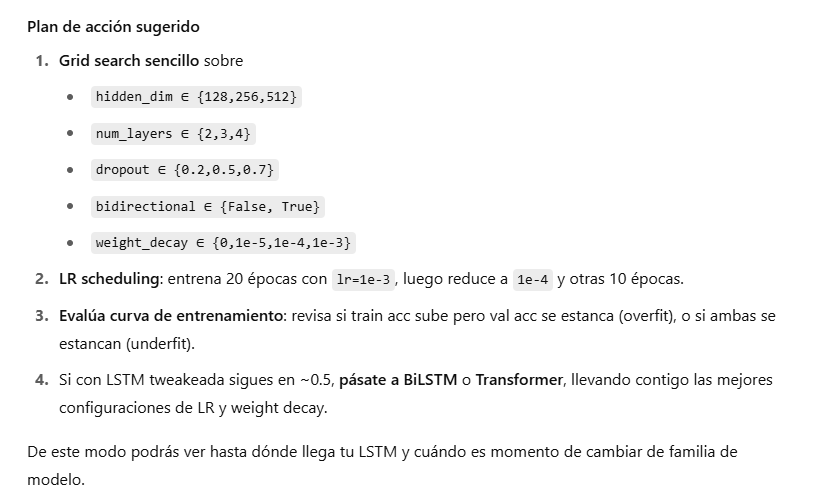



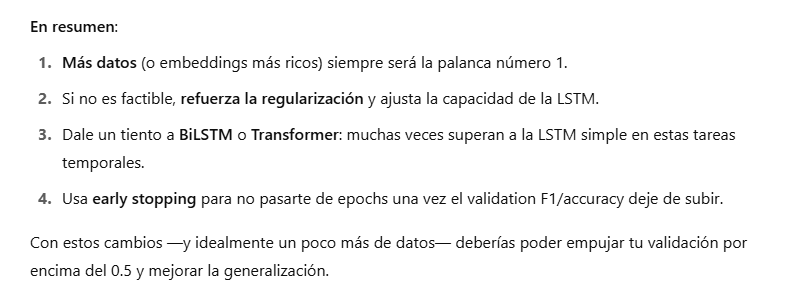

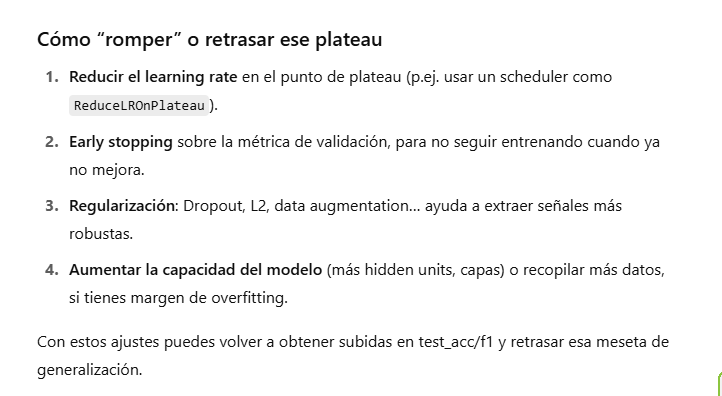

-------------------------------------------------------------------------------
## Modelo BiLSTM


## Preparación de datos, split y bucle de entrenamiento: BiLSTM

## Entrenamiento

-------------------------------------------------------------------------------
## Modelo Transformer

In [ ]:

# 3) Transformer con atención temporal
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        input_dim,
        model_dim=256,
        n_heads=4,
        num_layers=2,
        ff_dim=512,
        dropout=0.1
    ):
        """
        input_dim: dimensión D del embedding sin pooling (secuencia)
        model_dim: dimensión interna del transformer
        n_heads: número de cabezas de atención
        num_layers: número de capas Encoder
        ff_dim: dimensión del feed-forward
        dropout: dropout en capas Encoder
        """
        super().__init__()
        # Proyección de la dimensión de entrada al espacio model_dim
        self.token_proj = nn.Linear(input_dim, model_dim)
        # Capa TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=n_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        # Clasificador al token de posición 0 (CLS) o media de salidas
        self.classifier = nn.Linear(model_dim, 3)

    def forward(self, x, lengths=None):
        """
        x: FloatTensor (B, T, D)
        lengths: LongTensor (B,) opcional para masking
        """
        # x → proyección
        x = self.token_proj(x)  # (B, T, model_dim)

        # Generar máscara de padding si lengths dado
        if lengths is not None:
            max_len = x.size(1)
            mask = torch.arange(max_len, device=lengths.device) \
                   .unsqueeze(0) >= lengths.unsqueeze(1)
        else:
            mask = None

        # TransformerEncoder
        out = self.transformer(x, src_key_padding_mask=mask)  # (B, T, model_dim)

        # Agregado temporal: tomamos token 0 como representativo
        cls_token = out[:, 0, :]  # (B, model_dim)
        return self.classifier(cls_token)



## Preparación de datos, split y bucle de entrenamiento: Transformer
Con atención atemporal


In [ ]:
# Chunk 2: Collate function y preparación de datos para Transformer

import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

def collate_sequences(batch):
    """
    Recibe una lista de tuplas (tensor_seq, label).
    Devuelve:
      - padded: FloatTensor (B, T_max, D)
      - lengths: LongTensor (B,)
      - labels: LongTensor (B,)
    """
    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)
    padded  = pad_sequence(seqs, batch_first=True)
    labels  = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, labels

def prepare_transformer_data(df, norm='minmax', test_size=0.2):
    """
    Construye listas de muestras para train y test:
      - norm: 'minmax' o 'l2'
    Cada muestra es (tensor_seq, label).
    """
    feat_cols = [c for c in df.columns if c.startswith('feat_')]
    seqs, labs = [], []
    for vid, grp in df.groupby('video_ID'):
        arr = grp[feat_cols].values.astype(np.float32)  # (T, D)
        seqs.append(arr)
        labs.append(int(grp['shoot_zone'].iloc[0]))
    # Normalización
    if norm == 'minmax':
        all_frames = np.vstack(seqs)  # (sum_T, D)
        scaler = MinMaxScaler().fit(all_frames)
        seqs = [scaler.transform(s) for s in seqs]
    else:  # 'l2'
        seqs = [s / np.linalg.norm(s, axis=1, keepdims=True) for s in seqs]
    # Split estratificado
    idx = list(range(len(seqs)))
    idx_tr, idx_te = train_test_split(idx,
                                      test_size=test_size,
                                      stratify=labs,
                                      random_state=42)
    # Convertir a lista de tuplas (tensor_seq, label)
    train_list = [(torch.from_numpy(seqs[i]), labs[i]) for i in idx_tr]
    test_list  = [(torch.from_numpy(seqs[i]), labs[i]) for i in idx_te]
    return train_list, test_list


def run_training_transformer(model, train_loader, test_loader, epochs=20, lr=1e-3):
    """
    Función de entrenamiento específica para el modelo Transformer
    Args:
        model: Instancia de TransformerClassifier
        train_loader: DataLoader con datos de entrenamiento 
        test_loader: DataLoader con datos de test
        epochs: Número de épocas de entrenamiento
        lr: Learning rate para el optimizador
    Returns:
        history: Diccionario con métricas de entrenamiento
    """
    device = next(model.parameters()).device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'test_acc': [], 'test_f1': []}

    for ep in range(1, epochs + 1):
        # --- Fase de entrenamiento ---
        model.train()
        total_loss = 0
        for xb, lengths, yb in train_loader:
            xb = xb.to(device)
            lengths = lengths.to(device)
            yb = yb.to(device)
            
            optimizer.zero_grad()
            out = model(xb, lengths)
            loss = loss_fn(out, yb)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * yb.size(0)
        
        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)

        # --- Fase de evaluación ---
        model.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for xb, lengths, yb in test_loader:
                xb = xb.to(device)
                lengths = lengths.to(device)
                outputs = model(xb, lengths)
                preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        
        history['test_acc'].append(acc)
        history['test_f1'].append(f1)

        print(f"Época {ep:02d}/{epochs} | "
                f"loss {avg_loss:.4f} | "
                f"acc {acc:.4f} | "
                f"f1_macro {f1:.4f}")

    return history


## Entrenamiento

In [ ]:
import os
import pandas as pd
from torch.utils.data import DataLoader

# Configuración

DATA_DIR = "Gait_Embeddings_good"
NORMS = ['minmax', 'l2']
EPOCHS = 100  # Aumentado para mejor convergencia
BATCH_SIZE = 32  # Tamaño de batch para entrenamiento
LR = 1e-3
MODEL_DIM = 256  # Dimensión del transformer
N_HEADS = 8  # Número de cabezas de atención
N_LAYERS = 2  # Capas del encoder

results_transformer = []

for fname in os.listdir(DATA_DIR):
    if not fname.endswith('.csv'):
        continue
        
    print(f"\n--- Entrenando Transformer con {fname} ---")
    df = pd.read_csv(os.path.join(DATA_DIR, fname))
    
    for norm in NORMS:
        # Preparar datos
        train_list, test_list = prepare_transformer_data(df, norm=norm)
        tr_loader = DataLoader(train_list, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True, 
                             collate_fn=collate_sequences)
        te_loader = DataLoader(test_list, 
                             batch_size=BATCH_SIZE,
                             collate_fn=collate_sequences)

        # Crear y entrenar modelo
        model = TransformerClassifier(
            input_dim=df.filter(like='feat_').shape[1],
            model_dim=MODEL_DIM,
            n_heads=N_HEADS,
            num_layers=N_LAYERS,
            ff_dim=MODEL_DIM * 4,  # Típicamente 4x model_dim
            dropout=0.1
        ).to(DEVICE)
        
        history = run_training_transformer(
            model, 
            tr_loader, 
            te_loader,
            epochs=EPOCHS, 
            lr=LR
        )

        # Guardar resultados
        results_transformer.append({
            'extractor': fname,
            'model': 'Transformer',
            'normalization': norm,
            'accuracy': history['test_acc'][-1],
            'f1_macro': history['test_f1'][-1]
        })

# Guardar resultados
df_results = pd.DataFrame(results_transformer)
df_results.to_csv('transformer_results.csv', index=False)
print("\n✅ Resultados Transformer guardados en transformer_results.csv")

## Modelo TCN

## Entrenamiento


## Métricas posibles a usar
Precisión global (Accuracy)

F₁‐score macro
Matriz de confusión

Precisión (Precision) por clase

Exhaustividad (Recall) por clase

Balanced accuracy (accuracy balanceada)

Matthew’s Correlation Coefficient (MCC)

Curva ROC y AUC multiclass (one-vs-rest)

Log-Loss (Cross-Entropy Loss)

Brier Score

Cohen’s Kappa

Top-k accuracy (por ejemplo Top-2)

Time-to-decision (número medio de frames o ms antes del golpeo en que la predicción es estable)

Área bajo la curva Accuracy vs. Earliness

Tiempo de inferencia por muestra (latencia)

Número de parámetros / FLOPS / uso de memoria


## Preparación de los datos

Cuando tienes una secuencia de embeddings de forma (T,D) —es decir, 
T instantes en el tiempo y D características en cada uno— el pooling temporal la transforma en un único vector de dimensión D. Para cada característica j (j=1,…,D) se calcula bien la media de sus T valores (mean pooling) o 4bien su máximo (max pooling) a lo largo de toda la secuencia. De este modo, cada componente del vector resultante sintetiza la evolución completa de esa característica en el intervalo temporal.

Para el MLP, la función prepare_mlp_data agrupa cada secuencia (T,D) y aplica pooling (media o máximo) para convertirla en un vector plano de dimensión (D,), que luego normaliza y envía al modelo como input (batch, D). Por otro lado, SequenceDataset junto a collate_sequences conservan la secuencia completa de embeddings (T, D), la rellenan con ceros hasta T_max y devuelven también un tensor de longitudes reales, de modo que tu LSTM y Transformer reciben entradas de forma (batch, T_max, D) y usan esas longitudes para ignorar el padding durante el entrenamiento.

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------
# 3) Dataset y Collate para secuencias
# ------------------------------------------------
class SequenceDataset(Dataset):
    def __init__(self, df):
        feature_cols = [c for c in df.columns if c.startswith('feat_')]
        self.samples = []
        for vid, grp in df.groupby('video_ID'):
            arr = torch.from_numpy(grp[feature_cols].values).float()  # (T,D)
            label = int(grp['shoot_zone'].iloc[0])
            self.samples.append((arr, label))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

def collate_sequences(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs], dtype=torch.long)
    padded = pad_sequence(seqs, batch_first=True)  # (B, T_max, D)
    labels = torch.tensor(labels, dtype=torch.long)
    return padded, lengths, labels

# ------------------------------------------------
# 4) Funciones de preparación de datos
# ------------------------------------------------
def prepare_mlp_data(df, pooling='mean', test_size=0.2):
    # Extrae vectores (T,D) → pooling → (D,) y etiquetas
    feature_cols = [c for c in df.columns if c.startswith('feat_')]
    seqs, labs = [], []
    for vid, grp in df.groupby('video_ID'):
        arr = grp[feature_cols].values  # (T,D)
        vec = arr.mean(axis=0) if pooling=='mean' else arr.max(axis=0)
        seqs.append(vec)
        labs.append(int(grp['shoot_zone'].iloc[0]))
    X = np.stack(seqs).astype(np.float32)
    y = np.array(labs, dtype=np.int64)
    # Normalizamos MinMax
    X = MinMaxScaler().fit_transform(X)
    # Split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size,
                                          stratify=y, random_state=42)
    tr_ds = TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(ytr))
    te_ds = TensorDataset(torch.from_numpy(Xte), torch.from_numpy(yte))
    return tr_ds, te_ds

def prepare_seq_data(df, test_size=0.2):
    # Dataset completo
    full = SequenceDataset(df)
    labels = [full[i][1] for i in range(len(full))]
    idx_tr, idx_te = train_test_split(list(range(len(full))),
                                      test_size=test_size,
                                      stratify=labels,
                                      random_state=42)
    tr_ds = torch.utils.data.Subset(full, idx_tr)
    te_ds = torch.utils.data.Subset(full, idx_te)
    return tr_ds, te_ds

# ------------------------------------------------
# 5) Bucle de entrenamiento + evaluación
# ------------------------------------------------
def run_training(model, train_loader, test_loader, epochs=20, lr=1e-3):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {'train_loss':[], 'test_acc':[], 'test_f1':[]}

    for ep in range(1, epochs+1):
        # --- entrenamiento
        model.train()
        total_loss = 0
        for batch in train_loader:
            optim.zero_grad()
            if isinstance(model, MLPClassifier):
                xb, yb = batch
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                out = model(xb)
            else:
                xb, lengths, yb = batch
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                lengths = lengths.to(DEVICE)
                out = model(xb, lengths)
            loss = loss_fn(out, yb)
            loss.backward()
            optim.step()
            total_loss += loss.item() * yb.size(0)
        history['train_loss'].append(total_loss / len(train_loader.dataset))

        # --- evaluación
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in test_loader:
                if isinstance(model, MLPClassifier):
                    xb, yb = batch
                    xb = xb.to(DEVICE)
                    preds = model(xb).argmax(dim=1).cpu().numpy()
                else:
                    xb, lengths, yb = batch
                    xb = xb.to(DEVICE); lengths = lengths.to(DEVICE)
                    preds = model(xb, lengths).argmax(dim=1).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(yb.numpy())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        history['test_acc'].append(acc)
        history['test_f1'].append(f1)

        print(f"Ep{ep:02d} | loss {history['train_loss'][-1]:.4f} | "
              f"acc {acc:.4f} | f1_macro {f1:.4f}")

    return history

## Entrenamiento

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

data_dir = "Gait_Embeddings_good/"
extractors = [fname for fname in os.listdir(data_dir)]
pools      = ['mean', 'max']
norms      = ['minmax', 'l2']
classifiers = {
    'MLP':    MLPClassifier,
    #'LSTM':   LSTMClassifier,
    #'Transf': TransformerClassifier,
}

results = []

for csv_file in extractors:
    df = pd.read_csv(f'Gait_Embeddings_good/{csv_file}')
        
    # ————————————————————————
    # 1) MLP (usa pooling + norm)
    # ————————————————————————
    for pool in pools:
        for norm in norms:
            tr_ds, te_ds = prepare_mlp_data(df, pooling=pool)
            # crea loaders
            tr_loader = DataLoader(tr_ds, batch_size=32, shuffle=True)
            te_loader = DataLoader(te_ds, batch_size=32)

            model = MLPClassifier(input_dim=tr_ds[0][0].shape[0]).to(DEVICE)
            history = run_training(model, tr_loader, te_loader, epochs=20, lr=1e-3)

            # extraer métricas finales
            final_acc = history['test_acc'][-1]
            final_f1  = history['test_f1'][-1]

            results.append({
                'extractor':    csv_file,
                'model':        'MLP',
                'pooling':      pool,
                'normalization':norm,
                'accuracy':     final_acc,
                'f1_macro':     final_f1
            })
"""
    # ————————————————————————
    # 2) LSTM y Transformer (sin pooling/norm)
    # ————————————————————————
    tr_seq, te_seq = prepare_seq_data(df)
    for name, Cls in [('LSTM', LSTMClassifier), ('Transf', TransformerClassifier)]:
        tr_loader = DataLoader(tr_seq, batch_size=16, shuffle=True, collate_fn=collate_sequences)
        te_loader = DataLoader(te_seq, batch_size=16, collate_fn=collate_sequences)

        model = Cls(input_dim=df.filter(like='feat_').shape[1]).to(DEVICE)
        history = run_training(model, tr_loader, te_loader, epochs=20, lr=1e-3)

        final_acc = history['test_acc'][-1]
        final_f1  = history['test_f1'][-1]

        results.append({
            'extractor':     csv_file,
            'model':         name,
            'pooling':       None,
            'normalization': None,
            'accuracy':      final_acc,
            'f1_macro':      final_f1
        })
"""
# ————————————————————————
# Volcar a CSV
# ————————————————————————
df_res = pd.DataFrame(results)
df_res.to_csv('resultados_penaltis.csv', index=False)
print("✅ Resultados guardados en resultados_penaltis.csv")
print(df_res)


# Guadar el modelo final
#torch.save(model.state_dict(), 'model_final.pth')
